In [14]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [15]:
wc_data = pd.read_csv('datasets/wc98_workload_hour.csv')
wc_data.head(15)

,timestamp,count
0,1998-04-30 21:00:00,324
1,1998-04-30 22:00:00,51622
2,1998-04-30 23:00:00,46813
3,1998-05-01 00:00:00,39482
4,1998-05-01 01:00:00,36221
5,1998-05-01 02:00:00,36270
6,1998-05-01 03:00:00,39474
7,1998-05-01 04:00:00,36275
8,1998-05-01 05:00:00,28446
9,1998-05-01 06:00:00,29755


In [16]:
data_len = len(wc_data)

In [17]:
wc_data['timestamp'] = pd.to_datetime(wc_data.timestamp)
wc_data.head()

,timestamp,count
0,1998-04-30 21:00:00,324
1,1998-04-30 22:00:00,51622
2,1998-04-30 23:00:00,46813
3,1998-05-01 00:00:00,39482
4,1998-05-01 01:00:00,36221


In [18]:
wc_data['hour'], wc_data['day'], wc_data['month'] = wc_data.timestamp.dt.hour, wc_data.timestamp.dt.day, \
                                                    wc_data.timestamp.dt.month
wc_data.head()

,timestamp,count,hour,day,month
0,1998-04-30 21:00:00,324,21,30,4
1,1998-04-30 22:00:00,51622,22,30,4
2,1998-04-30 23:00:00,46813,23,30,4
3,1998-05-01 00:00:00,39482,0,1,5
4,1998-05-01 01:00:00,36221,1,1,5


In [19]:
# Select features and target
selected_features = ['day', 'month', 'hour']
features = wc_data[selected_features]
features = Variable(torch.FloatTensor([features.values]))


targets = wc_data['count']
targets = Variable(torch.FloatTensor(targets))

In [20]:
input_size = len(selected_features)
n_steps = 10
batch_size = 1
n_neurons = 30
n_outputs = 1

Set up RNN
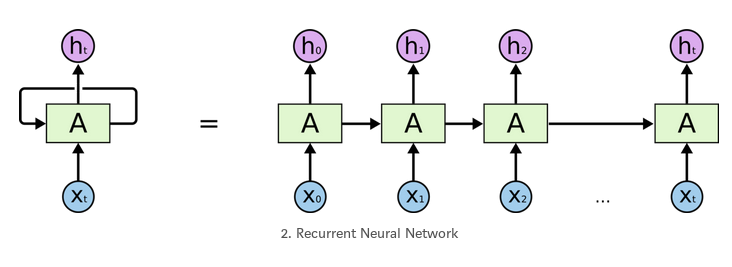

In [75]:
class RNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(RNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.rnn = nn.LSTM(self.n_inputs, self.n_neurons)
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
    
    def forward(self, X):
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        self.cell = self.init_cell()
        
        out, (self.hidden, self.cell) = self.rnn(X, (self.hidden, self.cell))
        out = self.FC(out)
        return out
        
    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.n_neurons)
    def init_cell(self):
        return torch.zeros(1, self.batch_size, self.n_neurons)

In [76]:
model = RNN(batch_size, n_steps, input_size, n_neurons, n_outputs)
print(model)

RNN(
  (rnn): LSTM(3, 30)
  (FC): Linear(in_features=30, out_features=1, bias=True)
)


In [84]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)
n_epochs = 1000
i = 0    
features = features.view(data_len, 1, input_size)

In [85]:
features.size()

torch.Size([1466, 1, 3])

In [86]:
# Train
for epoch in range(n_epochs):
    inputs = features[i%data_len: (i + 10)%data_len]
    train_targets = targets[(i + 1)%data_len: (i + 11)%data_len]
    i += 2
    if(i >= data_len - n_steps - 2):
        i = 0
    outputs = model(inputs)

    optimizer.zero_grad()
    loss = criterion(outputs[:, 0, 0], train_targets)
    loss.backward()
    optimizer.step()
    print("epoch: %d, loss: %1.3f" %(epoch + 1, loss.data[0]/1000000))

/home/tuna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


epoch: 1, loss: 5158.569
epoch: 2, loss: 4977.438
epoch: 3, loss: 4461.651
epoch: 4, loss: 3692.047
epoch: 5, loss: 2676.123
epoch: 6, loss: 1714.113
epoch: 7, loss: 1221.980
epoch: 8, loss: 1159.280
epoch: 9, loss: 1694.492
epoch: 10, loss: 2404.472
epoch: 11, loss: 3054.550
epoch: 12, loss: 3650.313
epoch: 13, loss: 3959.155
epoch: 14, loss: 3838.988
epoch: 15, loss: 3635.482
epoch: 16, loss: 3298.080
epoch: 17, loss: 2782.554
epoch: 18, loss: 2214.971
epoch: 19, loss: 1754.640
epoch: 20, loss: 1516.636
epoch: 21, loss: 1491.082
epoch: 22, loss: 1589.303
epoch: 23, loss: 1727.054
epoch: 24, loss: 1908.590
epoch: 25, loss: 1989.607
epoch: 26, loss: 1927.120
epoch: 27, loss: 1776.934
epoch: 28, loss: 1600.300
epoch: 29, loss: 1306.540
epoch: 30, loss: 957.308
epoch: 31, loss: 707.095
epoch: 32, loss: 605.438
epoch: 33, loss: 586.529
epoch: 34, loss: 642.770
epoch: 35, loss: 707.104
epoch: 36, loss: 792.008
epoch: 37, loss: 721.268
epoch: 38, loss: 540.926
epoch: 39, loss: 382.597
epoch

epoch: 328, loss: 3382.266
epoch: 329, loss: 5749.393
epoch: 330, loss: 7655.022
epoch: 331, loss: 8184.888
epoch: 332, loss: 8233.410
epoch: 333, loss: 6046.087
epoch: 334, loss: 3616.868
epoch: 335, loss: 1905.958
epoch: 336, loss: 1408.354
epoch: 337, loss: 661.975
epoch: 338, loss: 732.975
epoch: 339, loss: 1023.497
epoch: 340, loss: 2655.914
epoch: 341, loss: 4786.753
epoch: 342, loss: 6403.437
epoch: 343, loss: 6644.443
epoch: 344, loss: 6778.064
epoch: 345, loss: 5163.972
epoch: 346, loss: 3386.665
epoch: 347, loss: 2620.303
epoch: 348, loss: 3141.562
epoch: 349, loss: 3411.529
epoch: 350, loss: 3808.341
epoch: 351, loss: 3776.092
epoch: 352, loss: 2951.325
epoch: 353, loss: 1946.331
epoch: 354, loss: 1089.462
epoch: 355, loss: 470.738
epoch: 356, loss: 180.687
epoch: 357, loss: 619.420
epoch: 358, loss: 1198.381
epoch: 359, loss: 1592.776
epoch: 360, loss: 2267.035
epoch: 361, loss: 3181.044
epoch: 362, loss: 3096.601
epoch: 363, loss: 2681.281
epoch: 364, loss: 2118.576
epoch:

epoch: 629, loss: 248294.594
epoch: 630, loss: 1010168.625
epoch: 631, loss: 1211109.125
epoch: 632, loss: 1911867.125
epoch: 633, loss: 1825994.875
epoch: 634, loss: 1667827.875
epoch: 635, loss: 927270.875
epoch: 636, loss: 878681.062
epoch: 637, loss: 124435.023
epoch: 638, loss: 127741.422
epoch: 639, loss: 125471.977
epoch: 640, loss: 120441.258
epoch: 641, loss: 4840604.000
epoch: 642, loss: 5720790.000
epoch: 643, loss: 5954414.500
epoch: 644, loss: 7017059.000
epoch: 645, loss: 6993219.500
epoch: 646, loss: 2380694.250
epoch: 647, loss: 1481684.375
epoch: 648, loss: 1420469.250
epoch: 649, loss: 207265.828
epoch: 650, loss: 214310.469
epoch: 651, loss: 202156.531
epoch: 652, loss: 143194.391
epoch: 653, loss: 3909935.500
epoch: 654, loss: 4546782.000
epoch: 655, loss: 4575859.000
epoch: 656, loss: 5052320.500
epoch: 657, loss: 5197834.500
epoch: 658, loss: 1510240.625
epoch: 659, loss: 867810.625
epoch: 660, loss: 1047187.812
epoch: 661, loss: 419975.000
epoch: 662, loss: 47473

epoch: 934, loss: 1775.146
epoch: 935, loss: 1610.214
epoch: 936, loss: 1526.318
epoch: 937, loss: 1369.966
epoch: 938, loss: 1471.515
epoch: 939, loss: 1097.093
epoch: 940, loss: 792.507
epoch: 941, loss: 432.223
epoch: 942, loss: 242.952
epoch: 943, loss: 91.270
epoch: 944, loss: 149.577
epoch: 945, loss: 583.627
epoch: 946, loss: 1060.154
epoch: 947, loss: 1995.691
epoch: 948, loss: 2856.685
epoch: 949, loss: 3585.135
epoch: 950, loss: 3787.654
epoch: 951, loss: 6297.861
epoch: 952, loss: 5263.311
epoch: 953, loss: 4331.012
epoch: 954, loss: 3494.746
epoch: 955, loss: 2930.429
epoch: 956, loss: 169.516
epoch: 957, loss: 576.084
epoch: 958, loss: 1248.840
epoch: 959, loss: 2690.702
epoch: 960, loss: 4190.100
epoch: 961, loss: 4975.631
epoch: 962, loss: 4706.329
epoch: 963, loss: 4158.067
epoch: 964, loss: 3033.190
epoch: 965, loss: 1914.593
epoch: 966, loss: 1399.108
epoch: 967, loss: 1594.120
epoch: 968, loss: 1813.404
epoch: 969, loss: 1882.050
epoch: 970, loss: 1541.643
epoch: 971